## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

2024-02-16 20:25:44.113966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [2]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 10

# Prepare Training Data
1. Descárgate el dataset
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [8]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "/data/train/"
TEST_PATH = ROOT_PATH + "/data/test/"

In [9]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

### See Total In count

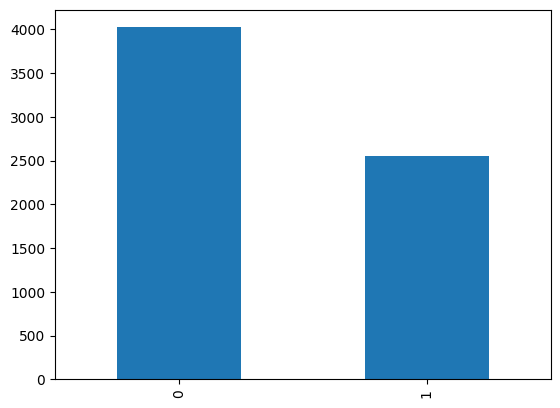

In [10]:
df['category'].value_counts().plot.bar();

# See sample image

In [ ]:
#!pip install -U scikit-image
#!pip install opencv-python

(271, 406, 3)
255


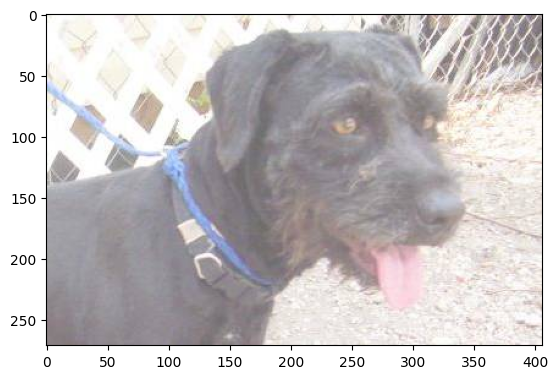

In [11]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [12]:
image

array([[[243, 244, 236],
        [233, 234, 226],
        [233, 234, 226],
        ...,
        [252, 244, 241],
        [211, 203, 201],
        [141, 133, 131]],

       [[247, 248, 240],
        [239, 240, 232],
        [236, 237, 229],
        ...,
        [244, 236, 233],
        [159, 151, 149],
        [160, 152, 150]],

       [[251, 252, 244],
        [248, 249, 241],
        [241, 242, 236],
        ...,
        [148, 140, 138],
        [178, 169, 170],
        [158, 149, 150]],

       ...,

       [[136, 127, 130],
        [137, 128, 131],
        [137, 128, 131],
        ...,
        [249, 244, 241],
        [250, 245, 242],
        [250, 245, 242]],

       [[136, 127, 130],
        [136, 127, 130],
        [137, 128, 131],
        ...,
        [252, 247, 244],
        [254, 249, 246],
        [254, 249, 246]],

       [[135, 126, 129],
        [136, 127, 130],
        [137, 128, 131],
        ...,
        [255, 250, 247],
        [255, 251, 248],
        [255, 250, 247]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (333, 499, 3)
Tamaño imagen reshape: (32, 32, 3)


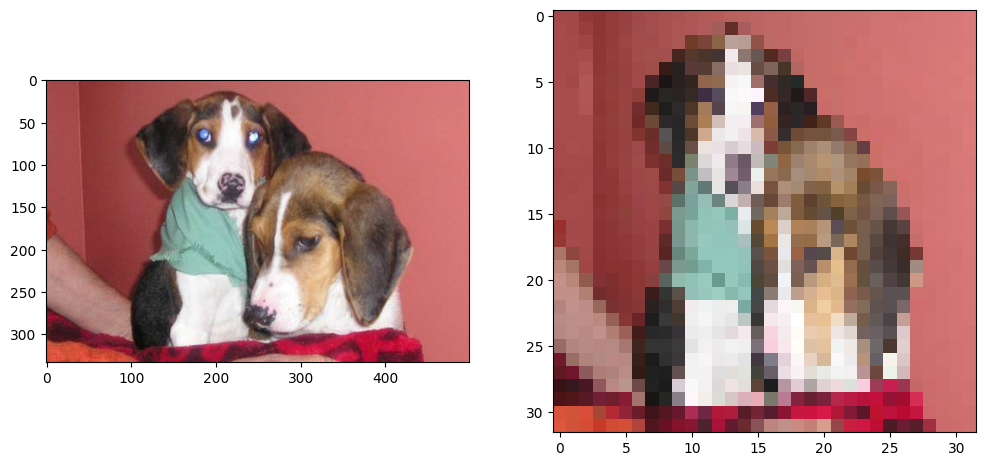

In [13]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Tamaño imagen original: (230, 306)


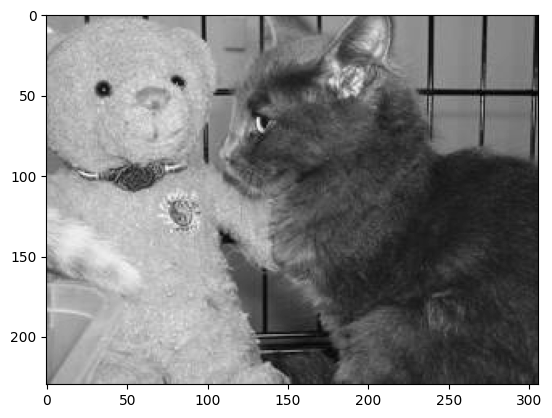

In [15]:
sample = random.choice(filenames)

image = cv2.imread(filename = TRAIN_PATH + sample, flags = cv2.IMREAD_GRAYSCALE)

print("Tamaño imagen original:", image.shape)
plt.imshow(image, cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [16]:
def read_data(path, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
        
        # Leer la imagen a color y aplicarle el resize
        image = imread(path + file)
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Guardo en X
        X.append(smallimage)
        
        category = file.split('.')[0]
        # Miro si es perro y gato para guardar en Y
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
        

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

print(X_train.shape)
print(X_test.shape)

(6576, 32, 32, 3)
(3456, 32, 32, 3)


(32, 32, 3)


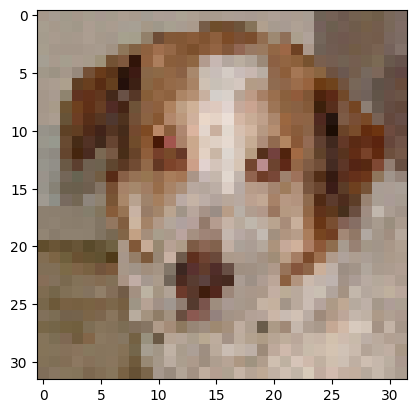

In [17]:
print(X_train[45].shape)# Displays an image from the training set 

plt.imshow(X_train[45]);

In [18]:
X_train[0]

array([[[ 37,  27,  18],
        [ 35,  28,  18],
        [ 36,  26,  17],
        ...,
        [103,  59,  32],
        [108,  68,  43],
        [105,  71,  44]],

       [[ 35,  25,  16],
        [ 41,  31,  22],
        [ 41,  29,  31],
        ...,
        [113,  70,  51],
        [107,  73,  46],
        [107,  79,  55]],

       [[ 37,  27,  18],
        [ 43,  33,  24],
        [194, 183, 191],
        ...,
        [111,  74,  45],
        [111,  76,  54],
        [109,  79,  55]],

       ...,

       [[ 87,  70,  54],
        [ 93,  78,  59],
        [ 92,  77,  58],
        ...,
        [ 28,  19,  14],
        [  9,   5,   0],
        [ 47,  35,  19]],

       [[ 81,  65,  50],
        [ 72,  56,  41],
        [ 74,  58,  42],
        ...,
        [  1,   6,   9],
        [ 17,  18,  14],
        [ 58,  39,  22]],

       [[ 60,  46,  37],
        [ 79,  63,  48],
        [ 85,  73,  51],
        ...,
        [ 39,  31,  20],
        [ 48,  34,  21],
        [ 50,  38,  24]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [19]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [20]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [21]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [22]:
X_train

array([[[[0.22745098, 0.3254902 , 0.41568627],
         [0.26666667, 0.36470588, 0.45098039],
         [0.25490196, 0.35686275, 0.42745098],
         ...,
         [0.5254902 , 0.32941176, 0.18431373],
         [0.48627451, 0.30588235, 0.17254902],
         [0.43921569, 0.2627451 , 0.17254902]],

        [[0.22745098, 0.34117647, 0.40392157],
         [0.24705882, 0.35294118, 0.41960784],
         [0.26666667, 0.35294118, 0.43529412],
         ...,
         [0.53333333, 0.3372549 , 0.19215686],
         [0.50588235, 0.30980392, 0.18039216],
         [0.43921569, 0.26666667, 0.16078431]],

        [[0.26666667, 0.34901961, 0.42352941],
         [0.2745098 , 0.38039216, 0.44705882],
         [0.27058824, 0.35686275, 0.43921569],
         ...,
         [0.5254902 , 0.32941176, 0.18431373],
         [0.50588235, 0.30980392, 0.18039216],
         [0.45098039, 0.27843137, 0.17254902]],

        ...,

        [[0.4745098 , 0.39607843, 0.3372549 ],
         [0.49411765, 0.40784314, 0.35294118]

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [23]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

Para cargar

In [24]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [25]:
from tensorflow import keras

"""
Defines a convolutional neural network architecture using Keras layers.

The architecture consists of:

- Conv2D layer with 64 filters and a 3x3 kernel, with ReLU activation and input shape set to the image size. This performs convolution on the input images.

- MaxPooling2D layer with 2x2 pooling to downsample the feature maps.

- Conv2D layer with 128 filters and 3x3 kernel, with ReLU activation. Additional convolution.

- MaxPooling2D layer with 2x2 pooling to further downsample. 

- Flatten layer to convert the feature maps to a 1D vector.

- Dense layer with 128 units and ReLU activation. Fully connected layer.

- Dense output layer with 1 unit and sigmoid activation. Outputs classification logits.
"""

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [26]:
# 64 filters, 3 rgb channels, 3x3 kernel    
64*(3*3)*3+ 64 

1792

In [27]:
128*(3*3)*3 + 64

3520

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               5

# Callbacks
#### Early Stopping

In [29]:
from keras.callbacks import EarlyStopping

# earlystop is an instance of EarlyStopping used to stop training early 
# if the validation loss has stopped improving. This helps prevent overfitting.

earlystop = EarlyStopping(patience=5)

In [30]:
"""
mcheckpoint: Creates a ModelCheckpoint callback that saves the model after each epoch. 

The callback saves the model to the filepath 'callback_model.keras'.
"""

from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.keras")

# Fit the model

In [31]:
"""Fits the model on batches with real-time data augmentation.

Arguments:
X_train: Training data tensor, split between train and test sets
y_train: Training labels tensor 
epochs: Number of epochs to train the model
batch_size: Size of training batches
callbacks: List of callbacks to apply during training
validation_split: Fraction of the training data to be used as validation data

Returns:
A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs.
"""
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2)
         #verbose=0)

Epoch 1/10
165/165 [==============================] - 19s 99ms/step - loss: 0.6578 - accuracy: 0.6175 - val_loss: 0.5918 - val_accuracy: 0.6809
Epoch 2/10
165/165 [==============================] - 16s 94ms/step - loss: 0.6132 - accuracy: 0.6618 - val_loss: 0.5768 - val_accuracy: 0.6892
Epoch 3/10
165/165 [==============================] - 14s 84ms/step - loss: 0.5499 - accuracy: 0.7224 - val_loss: 0.5486 - val_accuracy: 0.7211
Epoch 4/10
165/165 [==============================] - 19s 118ms/step - loss: 0.5126 - accuracy: 0.7460 - val_loss: 0.5213 - val_accuracy: 0.7401
Epoch 5/10
165/165 [==============================] - 21s 126ms/step - loss: 0.4735 - accuracy: 0.7732 - val_loss: 0.5517 - val_accuracy: 0.7378
Epoch 6/10
165/165 [==============================] - 16s 98ms/step - loss: 0.4291 - accuracy: 0.8036 - val_loss: 0.6202 - val_accuracy: 0.7128
Epoch 7/10
165/165 [==============================] - 15s 91ms/step - loss: 0.3819 - accuracy: 0.8230 - val_loss: 0.5341 - val_accurac

# Evaluate
Probemos los datos en el conjunto de test.

In [32]:
results = model.evaluate(X_test, y_test)
results

108/108 [==============================] - 2s 22ms/step - loss: 0.5705 - accuracy: 0.7558


[0.5705399513244629, 0.7557870149612427]

In [33]:
model.predict(X_test).round(0)

108/108 [==============================] - 3s 23ms/step


array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

108/108 [==============================] - 2s 20ms/step


array([[1161,  487],
       [ 357, 1451]])

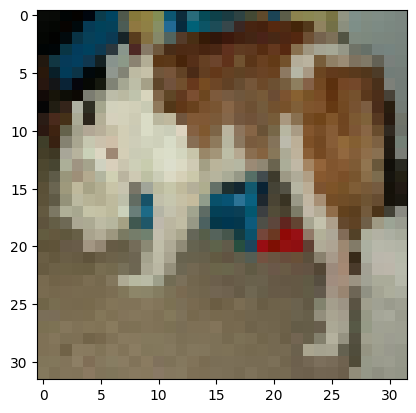

In [36]:
plt.imshow(X_test[-1]);

In [42]:
predictions = model.predict(X_test[-1:]).round(0)
predictions

1/1 [==============================] - 0s 71ms/step


array([[1.]], dtype=float32)

# Image data generator

In [38]:
# Replaces the category labels 0 and 1 with 'cat' and 'dog' strings

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
0,cat.2718.jpg,cat
1,cat.3406.jpg,cat
2,cat.1211.jpg,cat
3,dog.11102.jpg,dog
4,dog.11664.jpg,dog


In [39]:
from keras.preprocessing.image import ImageDataGenerator, load_img

# Rescale pixels to range 0-1
# Rotate image randomly by 15 degrees 
# Apply random shear up to 10%
# Zoom image randomly by 20%
# Randomly flip image horizontally
# Apply random width shift up to 10% 
# Apply random height shift up to 10%
# Generate augmented image batches

example_df = df.sample(n=1).reset_index(drop=True)
example_df

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = (128, 128)
)

Found 1 validated image filenames belonging to 1 classes.


In [43]:
example_df

,filename,category
0,dog.11052.jpg,dog


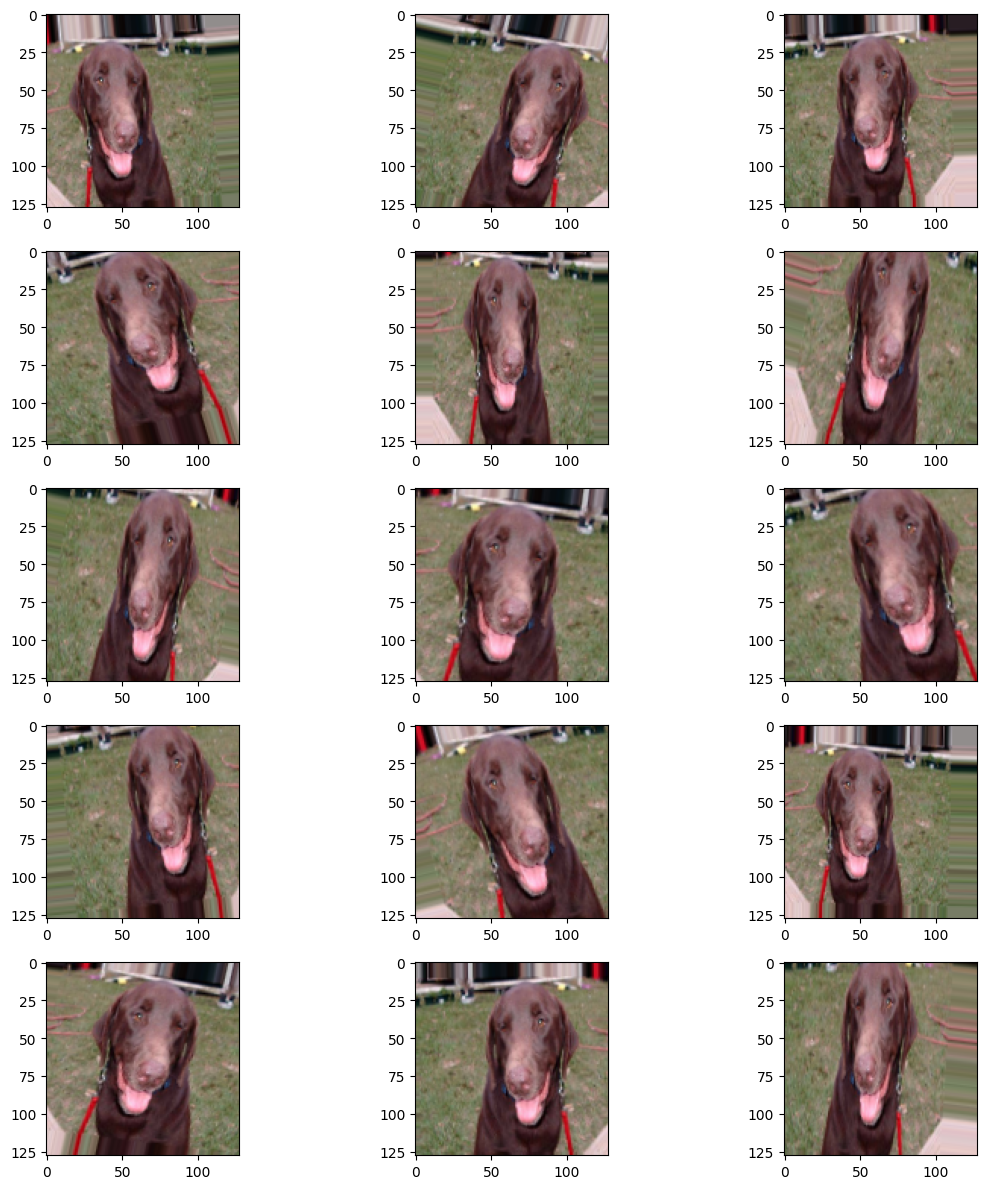

In [44]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Training Generator

In [45]:
train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [46]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 5260
Shape validation 1316


,filename,category
0,cat.818.jpg,cat
1,cat.3133.jpg,cat
2,cat.3204.jpg,cat
3,dog.10405.jpg,dog
4,cat.2145.jpg,cat


In [47]:
train_df.head()

,filename,category
0,cat.1088.jpg,cat
1,cat.1169.jpg,cat
2,cat.91.jpg,cat
3,dog.10489.jpg,dog
4,cat.485.jpg,cat


In [48]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5260 validated image filenames belonging to 2 classes.


### Validation Generator

In [49]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1316 validated image filenames belonging to 2 classes.


# Fit Model

In [50]:
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [51]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = validation_generator
)

Epoch 1/10
165/165 [==============================] - 41s 236ms/step - loss: 0.5392 - accuracy: 0.7369 - val_loss: 0.3513 - val_accuracy: 0.8571
Epoch 2/10
165/165 [==============================] - 36s 216ms/step - loss: 0.5116 - accuracy: 0.7485 - val_loss: 0.4720 - val_accuracy: 0.7637
Epoch 3/10
165/165 [==============================] - 36s 221ms/step - loss: 0.5069 - accuracy: 0.7458 - val_loss: 0.3748 - val_accuracy: 0.8427
Epoch 4/10
165/165 [==============================] - 32s 194ms/step - loss: 0.4956 - accuracy: 0.7671 - val_loss: 0.3497 - val_accuracy: 0.8663
Epoch 5/10
165/165 [==============================] - 41s 250ms/step - loss: 0.4908 - accuracy: 0.7572 - val_loss: 0.3886 - val_accuracy: 0.8245
Epoch 6/10
165/165 [==============================] - 45s 271ms/step - loss: 0.4826 - accuracy: 0.7707 - val_loss: 0.3754 - val_accuracy: 0.8275
Epoch 7/10
165/165 [==============================] - 35s 213ms/step - loss: 0.4637 - accuracy: 0.7823 - val_loss: 0.3835 - val_ac

In [52]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TEST_PATH)
filenames = os.listdir(TEST_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')
    
    
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [53]:
test_df

,filename,category
0,cat.12020.jpg,cat
1,dog.9469.jpg,dog
2,cat.11529.jpg,cat
3,dog.8777.jpg,dog
4,dog.8763.jpg,dog
...,...,...
3451,dog.9470.jpg,dog
3452,cat.11530.jpg,cat
3453,cat.12039.jpg,cat
3454,cat.11256.jpg,cat


In [54]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 3456 validated image filenames belonging to 2 classes.


In [55]:
len(test_generator)

108

In [56]:
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

108/108 [==============================] - 16s 148ms/step - loss: 0.4716 - accuracy: 0.7731
test loss, test acc: [0.47161221504211426, 0.7731481194496155]


In [57]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

108/108 [==============================] - 4s 33ms/step - loss: 0.4624 - accuracy: 0.7786
test loss, test acc: [0.4624384343624115, 0.7786458134651184]


# Virtualize Training

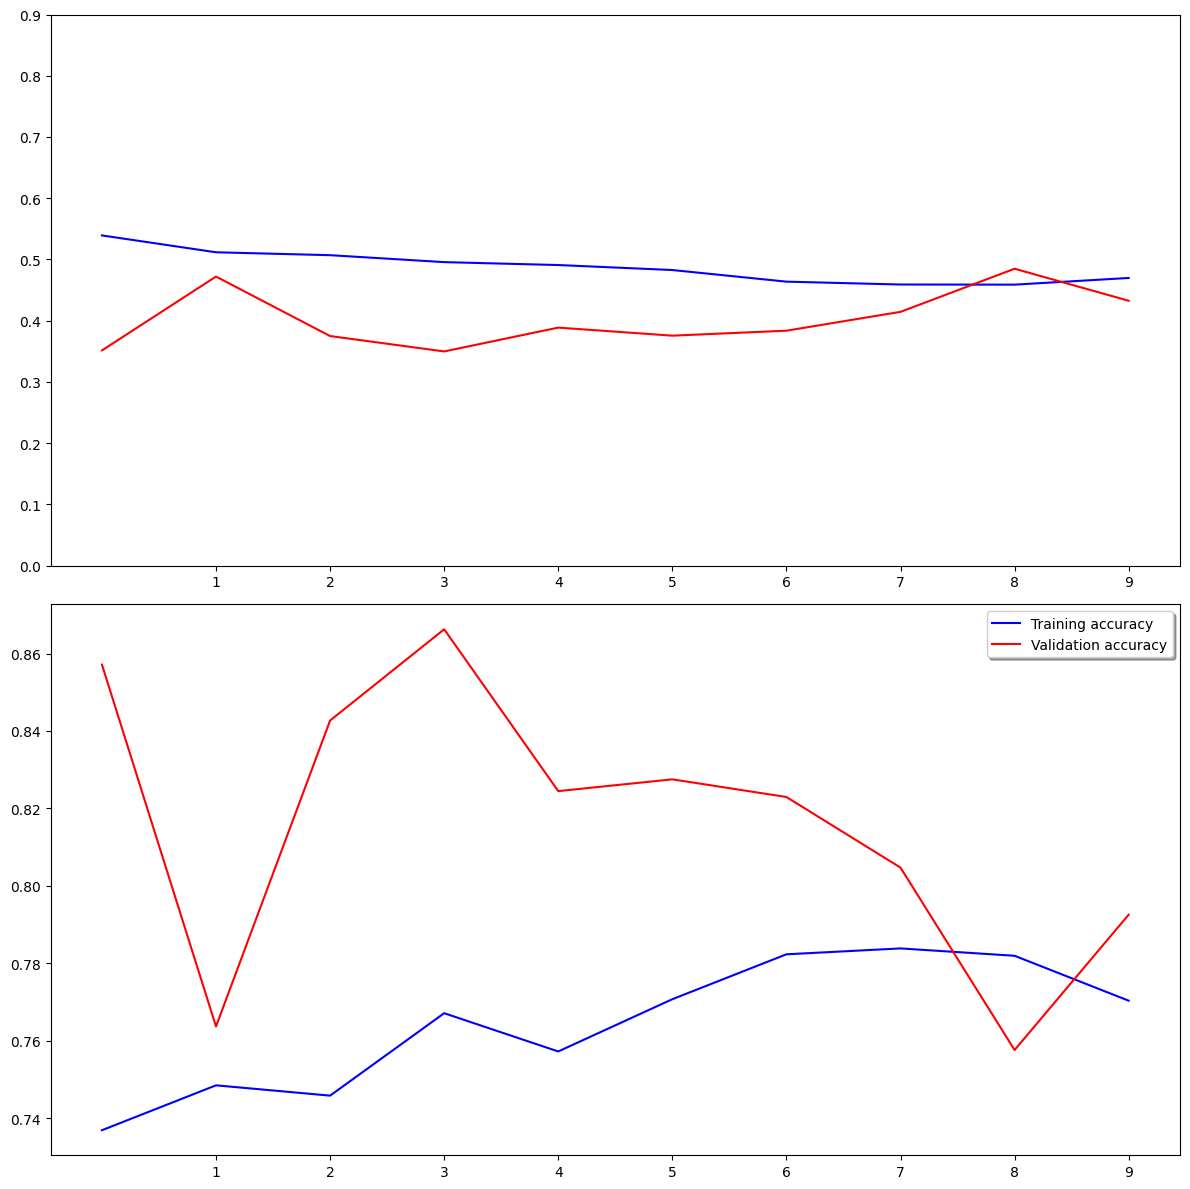

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()